# Multi-Class Image Classification for Oxford-IIIT Pets dataset

**Team Member:**
* Dang Quoc Anh Duy - ITDSIU20015
* Nguyen Duc Toan - ITCSIU21

___
### Objectives:
* Perform data preprocessing and EDA on pets dataset
* Implement classification using **ResNet50_V2** and **MobileNet_V2**
* Evaluate on the performance and some analysis

___
### Dataset Info:
- Oxford-IIIT dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/)
- The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.
- While there are various sources where the image dataset can be downloaded from, we will use the `tfds` module to load the images.
- `tfds` stands for Tensorflow Datasets, and it is a Tensorflow component that defines a collection of datasets ready-to-use with TensorFlow

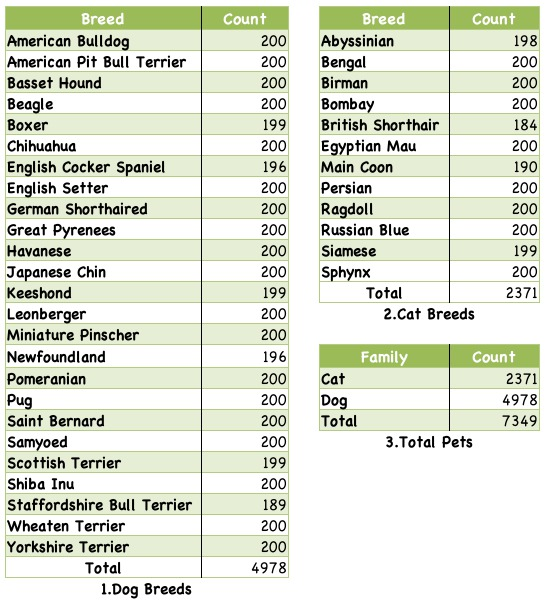

In [ ]:
from IPython.display import Image
Image('pet_dataset_info.jpg')

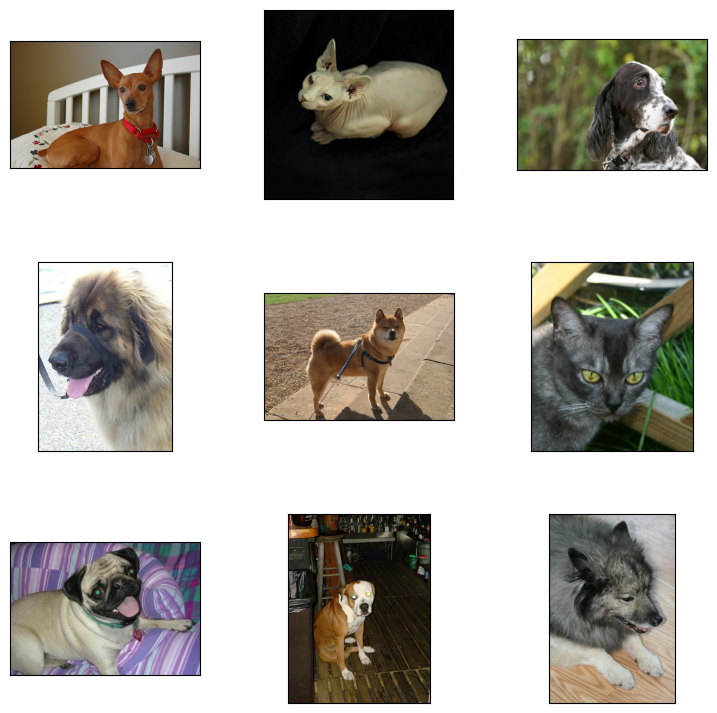

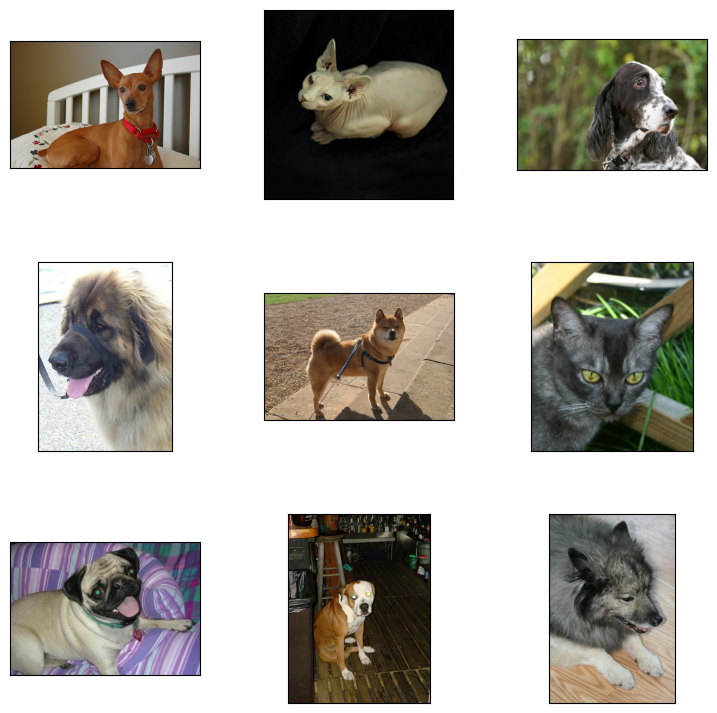

In [ ]:
tfds.show_examples(train_raw, ds_info, image_key='image')

___
### Import necessary library

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Year 4/Artificial Intelligence/')

In [ ]:
!ls

'CNN Classification.ipynb'				   models
 colab_pdf.py						   pet_dataset_info.jpg
'Image Classification Models.ipynb'			   __pycache__
'Image Classification on Oxford-IIIT Pets dataset.ipynb'   ref
'MobileNet_V2 Classification.ipynb'			   test-data
 model.png


In [ ]:
!pip install tensorflow_data_validation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import callbacks
from keras import layers, models
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

### Data Preprocessing + Exploratory Data Analysis

#### Load and split the raw image data
- We load the pets dataset (named as `oxford_iiit_pet` in `tfds`) as a `tf.data.Dataset` object, and the raw dataset has two sets: train and test
- For our project, we want to split the dataset into three sets: train set, validation set, and test set.
- The train/val split is set as 90:10 ratio, and we also ensure the images are shuffled
- We can use percentages (%) to slice the datasets, so that there is no need for us to input the exact index for splitting
- Note that when we set the parameter `with_info=True`, we will also obtain the dataset documentation along with the images.
- This dataset documentation (which we save as `ds_info`) contains a host of information, but perhaps the most important one is the label name (i.e. pet breed) for each image class
- The output will be captured as a tuple: (image datasets, dataset information) when we set `as_supervised=True`

In [ ]:
# Load data using tfds
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:80%]',
                                                          'train[80%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5H05C0/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5H05C0/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 2944
Number of validation samples: 736
Number of test samples: 3669


,file_name,image,label,segmentation_mask,species
0,Sphynx_158.jpg,,33 (Sphynx),,0 (Cat)
1,english_cocker_spaniel_135.jpg,,12 (english_cocker_spaniel),,1 (Dog)
2,British_Shorthair_181.jpg,,9 (British_Shorthair),,0 (Cat)
3,Siamese_161.jpg,,32 (Siamese),,0 (Cat)
4,Sphynx_178.jpg,,33 (Sphynx),,0 (Cat)

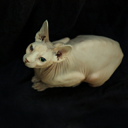
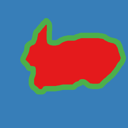
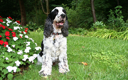
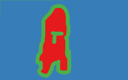
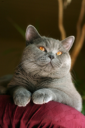
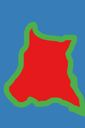
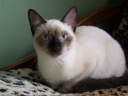
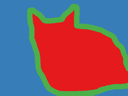
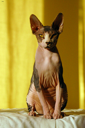
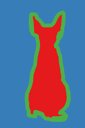

In [ ]:
# Display several examples of the training set
examples = tfds.as_dataframe(train_raw.take(5), ds_info)
examples

In [ ]:
# Get number of classes
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)

Number of classes: 37


In [ ]:
ds_info.features['label'].names

['Abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'boxer',
 'British_Shorthair',
 'chihuahua',
 'Egyptian_Mau',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'Maine_Coon',
 'miniature_pinscher',
 'newfoundland',
 'Persian',
 'pomeranian',
 'pug',
 'Ragdoll',
 'Russian_Blue',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'Siamese',
 'Sphynx',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [ ]:
ds_info.features['species'].names

['Cat', 'Dog']

In [ ]:
# Extract species names
species_names = ds_info.features['species'].names
species_list = []

# Iterate over the train dataset to populate the list with species information
for example in train_raw:
    species = example['species'].numpy()
    species_list.append(species)

species_counts = pd.Series(species_list).value_counts(sort=True)
species_counts.index = species_counts.index.map(lambda x: species_names[x])

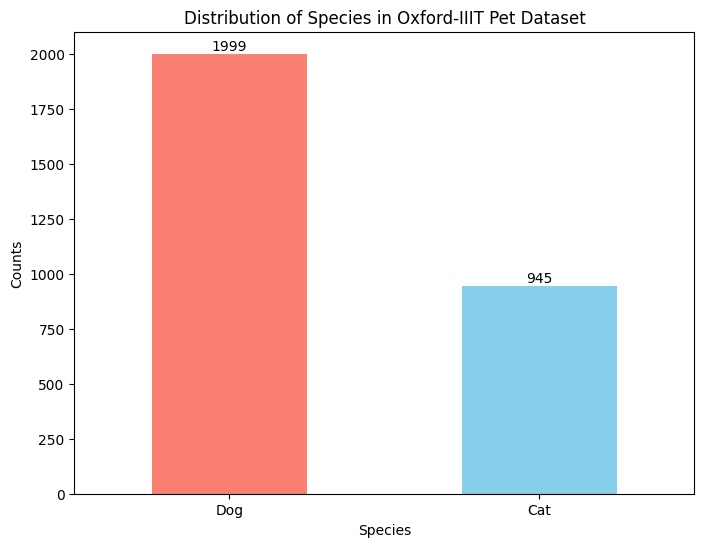

In [ ]:
# Plotting the distribution of species with count number on each bar
plt.figure(figsize=(8, 6))
bar_plot = species_counts.plot(kind='bar', color=['salmon', 'skyblue'])

plt.xlabel('Species')
plt.ylabel('Counts')
plt.title('Distribution of Species in Oxford-IIIT Pet Dataset')

# Add count number on each bar
for i, count in enumerate(species_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.xticks(rotation=0)
plt.show()

In [ ]:
def get_value_counts(ds, ds_info):
    label_names = ds_info.features['label'].names
    label_list = []

    for example in ds:
        label = example['label'].numpy()
        label_list.append(label)

    label_counts = pd.Series(label_list).value_counts(sort=True)
    label_counts.index = label_counts.index.map(lambda x: label_names[x])

    return label_counts

In [ ]:
get_value_counts(train_raw, ds_info)

american_pit_bull_terrier     87
Ragdoll                       86
leonberger                    86
yorkshire_terrier             86
english_setter                85
wheaten_terrier               84
beagle                        83
keeshond                      83
Maine_Coon                    83
american_bulldog              82
miniature_pinscher            82
staffordshire_bull_terrier    82
Siamese                       82
Bengal                        82
British_Shorthair             81
Persian                       81
havanese                      81
basset_hound                  80
newfoundland                  80
scottish_terrier              80
Russian_Blue                  80
great_pyrenees                79
german_shorthaired            79
shiba_inu                     78
chihuahua                     78
Bombay                        77
pug                           77
japanese_chin                 76
Abyssinian                    76
boxer                         76
Birman    

In [ ]:
# Build the custom function to display image and label name
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

In [ ]:
# Function to obtain the name for the label integer
get_label_name = ds_info.features['label'].int2str

Image shape:  (500, 334, 3)


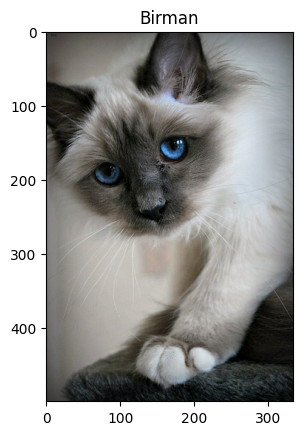

In [ ]:
view_single_image(train_raw)

In [ ]:
# Function to get the height and width of images from a dataset
def get_image_dimensions(dataset):
    heights = []
    widths = []
    for image, label in dataset:
        heights.append(image.shape[0])
        widths.append(image.shape[1])
    return heights, widths

# Collect heights and widths from train, validation, and test datasets
train_heights, train_widths = get_image_dimensions(train_raw)
val_heights, val_widths = get_image_dimensions(val_raw)
test_heights, test_widths = get_image_dimensions(test_raw)

# Combine all heights and widths
all_heights = train_heights + val_heights + test_heights
all_widths = train_widths + val_widths + test_widths

# Count the frequency of each height and width
height_counter = Counter(all_heights)
width_counter = Counter(all_widths)

# Separate keys and values for plotting
heights, height_counts = zip(*height_counter.items())
widths, width_counts = zip(*width_counter.items())

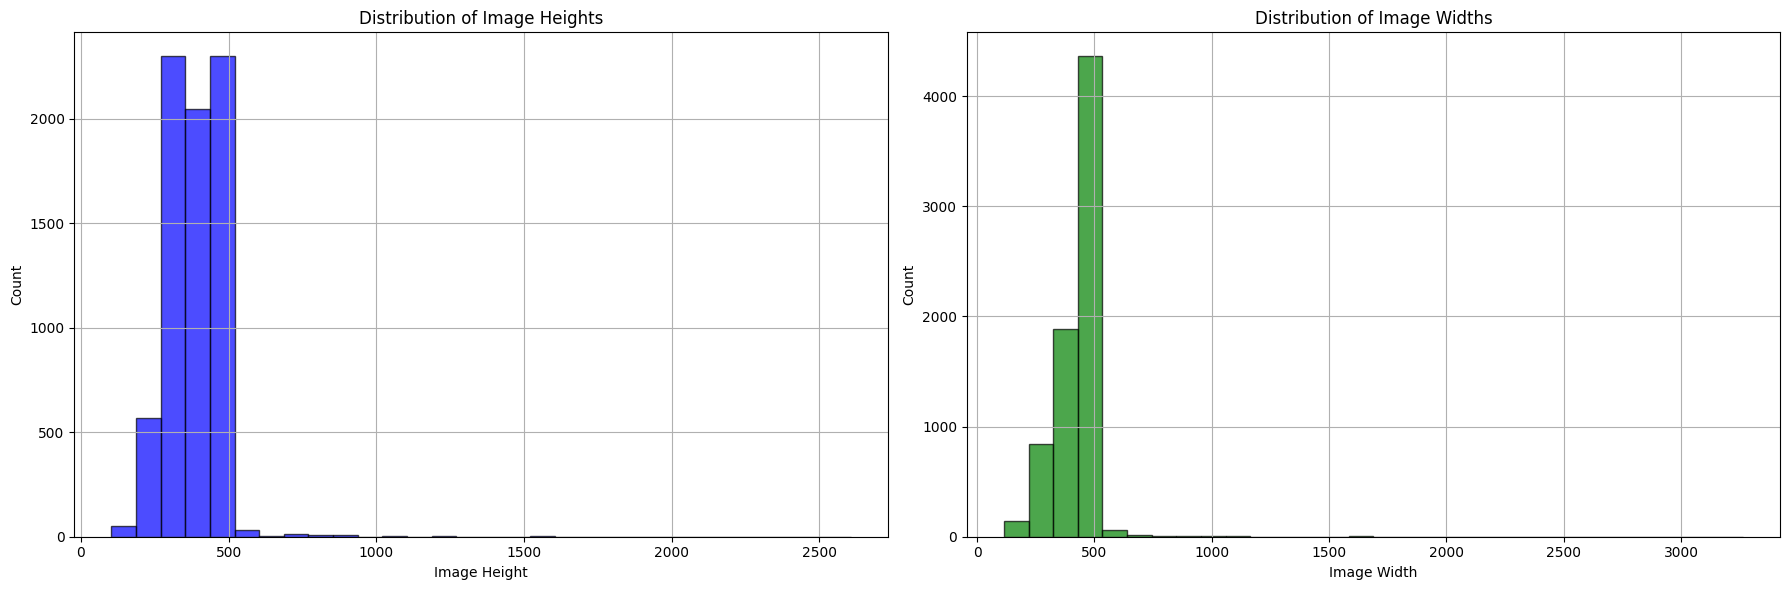

In [ ]:
# Plot the distributions side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the histogram for heights
axes[0].hist(all_heights, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Image Height')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Image Heights')
axes[0].grid(True)

# Plot the histogram for widths
axes[1].hist(all_widths, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Image Width')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Image Widths')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### (i) Image Resizing
- Because the raw images come in different sizes, we want to resize them to the same size before parsing them into the neural network later
- More specifically, we want both the length and width to be 224 pixels (which is what ResNet50_V2 expects)

In [ ]:
IMG_SIZE = 224

# Resize images
def resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds = train_raw.map(resize)
val_ds = val_raw.map(resize)
test_ds = test_raw.map(resize)

In [ ]:
# View the shape of data after transformation
train_ds.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

___
### (ii) Label One-hot Encoding
- There are 37 classes (i.e. pet breeds) in the dataset that we are using for multi-class image classification
- As such, we proceed to one-hot encode the labels so that we get a output vector of length 37

In [ ]:
# Encoding the target label
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
num_classes = 37

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [ ]:
for value in train_ds.take(1):
    print(value)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 83.52266 ,  58.81318 ,  27.091518],
        [ 83.60491 ,  58.604908,  28.604912],
        [ 84.20197 ,  59.20197 ,  28.262775],
        ...,
        [121.39852 , 115.91192 , 111.42531 ],
        [114.49232 , 106.64411 ,  95.795906],
        [113.23261 , 106.23261 ,  98.23261 ]],

       [[ 83.96205 ,  58.512375,  29.757713],
        [ 82.95901 ,  57.848213,  28.180584],
        [ 84.021706,  59.13901 ,  28.080357],
        ...,
        [121.664215, 114.664215, 108.664215],
        [114.60718 , 106.139854,  96.529884],
        [114.6249  , 107.6249  ,  99.6249  ]],

       [[ 83.816345,  58.899475,  28.433573],
        [ 84.33444 ,  58.967136,  28.967136],
        [ 85.      ,  60.541553,  29.62855 ],
        ...,
        [120.41651 , 113.41651 , 105.41651 ],
        [114.82369 , 106.12728 ,  96.97549 ],
        [115.80254 , 108.80254 , 100.80254 ]],

       ...,

       [[195.78009 , 198.93187 , 195.54794 ],
        [195

From the printout, we can see that each dataset object (i.e., `train_ds`, `val_ds`, and `test_ds`) has two components each:
- Images of shape (224,224,3)
- Label vector of shape (37,)

The values in each component has also been casted to a float data type, which is what we want for the deep learning model later. Another point to keep in mind is that these objects are **generators**, meaning that they only return one set of image and label when we iterate over it one value at a time.

### (iii) Data Augmentation
- Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.
- The purpose is to reduce model overfitting by exposing our model to variations and small transformations in the original data. It is useful especially when we do not have a large dataset.
- Note that the image augmentation needs to be realistic. For example, flipping car images upside down may not be the best choice here since we expect most cars to be photographed with the wheels on the ground (barring severe accidents)
- To perform data augmentation, we use the Keras preprocessing layers API. Each type of image augmentation that we want to introduce is defined as a layer within a Keras Sequential class.
- We will only perform a random horizontal flip for the images for the sake of simplicity, though do note that there is a wide range of different augmentations available to us: https://keras.io/api/layers/preprocessing_layers/image_augmentation/

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

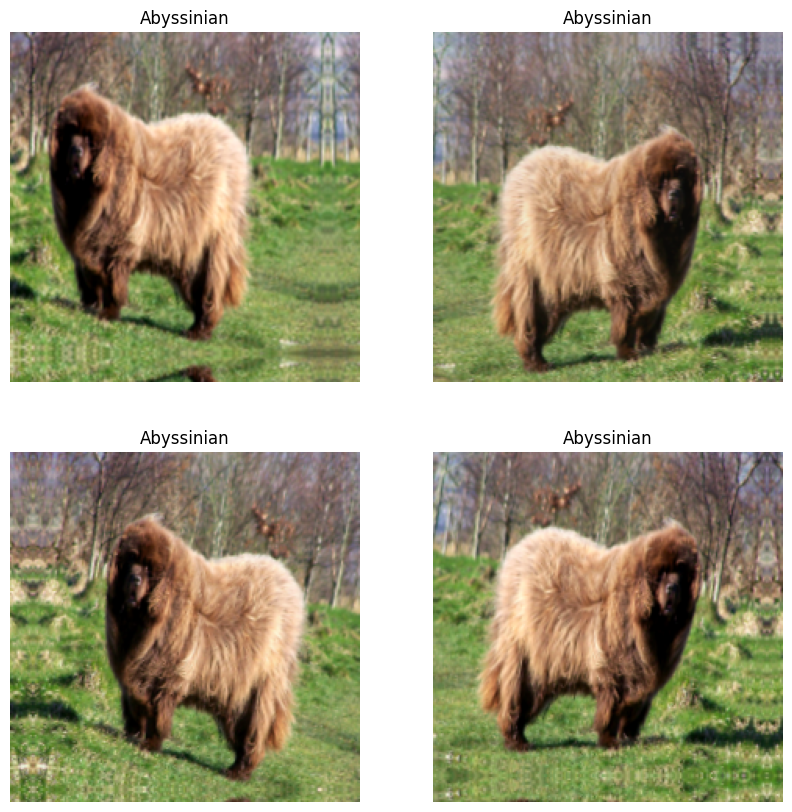

In [ ]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

### (iv) Batching and Prefetching
- We can batch the data and use prefetching to optimize loading speed and model efficiency
- A batch size of 32 is a good value to start with
- The number of elements to prefetch can be automatically determined by making use of `tf.data.AUTOTUNE`, which prompt the runtime to tune the value dynamically for us.

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds = train_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

- After batching and prefetching, note that the dataset object has been transformed such that the earlier functions to view images will no longer work
- Caching (with `.cache()`) is another way to speed up the process, where we store dataset either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. However, note that this can cause RAM limit issues in the free version of Google Colab, thus caching has been excluded in this step.

___
## (5) Model Setup
- With the data prepared, it is time to define the model we want to use for the multi-class classification task
- For this task, we will make use of transfer learning so that we do not need to train a deep learning model from scratch (which is tedious and requires plenty of data)
- Keras comes with a host of pre-trained models that we can leverage for transfer learning: https://keras.io/api/applications/
- We will be using ResNet50V2 given that it offers a good balance of accuracy, size, and speed
- More information about ResNet can be found here: https://keras.io/api/applications/resnet/

### (i) Setup base model
- Instantiate a ResNet50V2 object from `keras.applications`
- Set `include_top=False` because we want to remove the top layers of the pre-trained model (that was trained to classify ImageNet) and introduce our own final layers for our specific car image classification task
- Keep the weights as `imagenet`, because we want to keep the ResNet weights that were trained on the ImageNet dataset
- This process is known as transfer learning, because we use the pre-trained ImageNet weights

In [ ]:
IMG_SIZE = 224

base_model = keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")

94668760/94668760 [==============================] - 1s 0us/step


### (ii) Freeze pre-trained weights of the base model
- When a trainable weight becomes non-trainable, its value is no longer updated during training.

In [ ]:
# Freeze the base_model
base_model.trainable = False

### (iii) Modify inputs
- We pre-process the inputs (i.e., images) so that they are compatible with what the pre-trained ResNet50v2 architecture expects

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

In [ ]:
x = keras.applications.resnet_v2.preprocess_input(x)

In [ ]:
x = base_model(x, training=False)

In [ ]:
x.shape

TensorShape([None, 7, 7, 2048])

- Although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model.
- This means that the batch normalization layers inside will not update their batch statistics (i.e., mean and variance)
- If they did, they would wreak havoc on the representations learned by the model so far because the training done would have been undone.

### (iv) Rebuild top layers
- Given that we have removed the top ImageNet classifier layer of ResNet50V2, we can now build a custom top layer that is specific to our image classification task i.e., classify an image based on the 37 different pet breeds types.

In [ ]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)

#### Display model summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

#### Compile model
- Utilize the commonly used Adam optimizer (leave the learning rate as default)
- Since it is a multi-class classification, we will use categorical cross entropy and categorical accuracy as our loss and performance metric respectively

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Include early stopping
- Prevent overfitting

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

___
## (6) Model Training

#### Fit model
- Ensure that the Google Colab runtime using GPU hardware accelerator
- Fit the model over the training dataset for 15 epochs
- Store the training output as a variable called `history`

In [ ]:
EPOCHS = 25

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/25
92/92 [==============================] - 652s 7s/step - loss: 1.3356 - categorical_accuracy: 0.6230 - val_loss: 0.5939 - val_categorical_accuracy: 0.8519
Epoch 2/25
92/92 [==============================] - 596s 6s/step - loss: 0.4229 - categorical_accuracy: 0.8635 - val_loss: 0.4462 - val_categorical_accuracy: 0.8777
Epoch 3/25
92/92 [==============================] - 608s 7s/step - loss: 0.2824 - categorical_accuracy: 0.9124 - val_loss: 0.3867 - val_categorical_accuracy: 0.8940
Epoch 4/25
92/92 [==============================] - 625s 7s/step - loss: 0.2197 - categorical_accuracy: 0.9276 - val_loss: 0.3851 - val_categorical_accuracy: 0.8832
Epoch 5/25
92/92 [==============================] - 591s 6s/step - loss: 0.1829 - categorical_accuracy: 0.9440 - val_loss: 0.3750 - val_categorical_accuracy: 0.8940
Epoch 6/25
92/92 [==============================] - 591s 6s/step - loss: 0.1407 - categorical_accuracy: 0.9569 - val_loss: 0.3587 - val_categorical_accuracy: 0.8927
Epoch 7/25

In [ ]:
model.save("models/ResNet50_V2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Plot the accuracy of training and validation sets over epochs

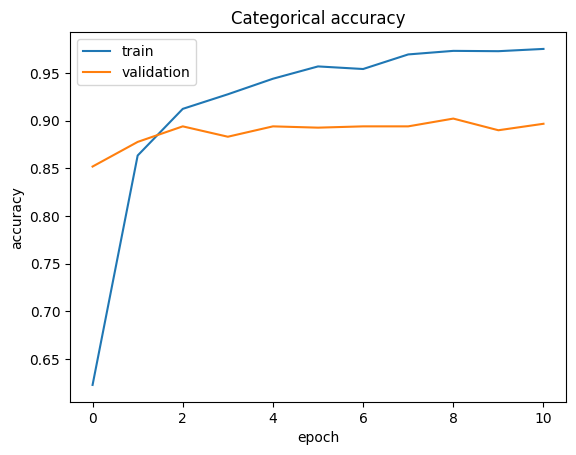

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

___
## (7) Model Evaluation

In [ ]:
model = keras.models.load_model("models/ResNet50_V2.h5")

In [ ]:
preds = model.predict(test_ds)

#### Evaluate model on test dataset

In [ ]:
result = model.evaluate(test_ds)

114/114 [==============================] - 13s 112ms/step - loss: 0.4689 - categorical_accuracy: 0.8607


#### Display results

In [ ]:
dict(zip(model.metrics_names, result))

{'loss': 0.46886688470840454, 'categorical_accuracy': 0.8607456088066101}

___
## (8) Finetune Model (OPTIONAL)
- Once our model has converged on the new data, we can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate (e.g., 0.0001)
- This is an optional last step that can potentially give us incremental improvements. However, it can also potentially lead to quick overfitting.

#### Unfreeze base model
- We only want to unfreeze top 15 layers that are NOT batch normalization layers

In [ ]:
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

#### Recompile model
- This step needs to be done to take into account the change above, where we set the `trainable` attribute of the base model layers to True

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Set a very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Retrain model
- Using fewer epochs given the high risk of overfitting in fine-tuning

In [ ]:
EPOCHS = 5

history_2 = model.fit(train_ds,
                      epochs=EPOCHS,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks =[earlystopping])

Epoch 1/5
103/103 [==============================] - 43s 348ms/step - loss: 0.0780 - categorical_accuracy: 0.9800 - val_loss: 0.3673 - val_categorical_accuracy: 0.8835
Epoch 2/5
103/103 [==============================] - 35s 340ms/step - loss: 0.0423 - categorical_accuracy: 0.9936 - val_loss: 0.3574 - val_categorical_accuracy: 0.8892
Epoch 3/5
103/103 [==============================] - 35s 337ms/step - loss: 0.0266 - categorical_accuracy: 0.9967 - val_loss: 0.3384 - val_categorical_accuracy: 0.8977
Epoch 4/5
103/103 [==============================] - 35s 336ms/step - loss: 0.0158 - categorical_accuracy: 0.9994 - val_loss: 0.3450 - val_categorical_accuracy: 0.8807
Epoch 5/5
103/103 [==============================] - 35s 338ms/step - loss: 0.0138 - categorical_accuracy: 0.9991 - val_loss: 0.3516 - val_categorical_accuracy: 0.8835


#### Display fine-tuned model results

In [ ]:
result_2 = model.evaluate(test_ds)

dict(zip(model.metrics_names, result_2))

114/114 [==============================] - 13s 112ms/step - loss: 0.4471 - categorical_accuracy: 0.8717


{'loss': 0.44707489013671875, 'categorical_accuracy': 0.8717105388641357}

We can see that the final step of unfreezing several layers of the model has indeed given the model performance a good boost.